In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist, obs_hci
from pynrc.obs_nircam import plot_contrasts, plot_contrasts_mjup, planet_mags, plot_planet_patches

pynrc.setup_logging('WARNING', verbose=False)

[     pynrc:INFO]   jwst_backgrounds is not installed and will not be used for bg estimates.


In [3]:
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u

from astropy.convolution import convolve, convolve_fft
from scipy import fftpack

## Read in stellar photometry

In [4]:
# Read in master source table and FITS file
tbl = ascii.read('MASTER.ISO.XYVJHKRD.txt')

In [5]:
# Read in F210M and F335M photometry info and merge with master catalog
# These were derived using Kevin Volk's JWST Magnitude Conversion tool
names = ['Color', 'ACS_F606W', 'F210M', 'F335M', 'RA', 'Dec']
include_names = names[2:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F210M.F335M.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [6]:
# F200W and F356W
names = ['Color', 'ACS_F606W', 'F200W', 'F356W', 'RA', 'Dec']
include_names = names[2:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F200W.F356W.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [7]:
# F444W
names = ['Color', 'ACS_F606W', 'F200W', 'F444W', 'RA', 'Dec']
include_names = names[3:4]
tbl2 = ascii.read('MASTER.ISO.NRC.F200W.F444W.txt', names=names, include_names=include_names)
for k in tbl2.keys():
    tbl.add_column(tbl2[k])

In [8]:
tbl

x,y,vcal,jcal,hcal,kcal,j2mass,h2mass,k2mass,jmodel,hmodel,kmodel,juse,huse,kuse,ra,dec,F210M,F335M,F200W,F356W,F444W
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3313.07,744.06,21.044,30.0,30.0,30.0,30.0,30.0,30.0,19.517,19.048,18.98,19.517,19.048,18.98,80.37930584,-69.47107232,18.98164,18.93709,18.99291,18.93495,18.98836
3486.84,747.89,20.787,30.0,30.0,30.0,30.0,30.0,30.0,19.24,18.763,18.695,19.24,18.763,18.695,80.38441657,-69.46947496,18.69659,18.65135,18.70799,18.64916,18.70393
3415.99,748.84,21.502,30.0,30.0,30.0,30.0,30.0,30.0,20.02,19.568,19.503,20.02,19.568,19.503,80.38240033,-69.47015164,19.50474,19.46174,19.51572,19.45972,19.50997
3550.82,750.81,21.823,30.0,30.0,30.0,30.0,30.0,30.0,20.629,20.284,20.239,20.629,20.284,20.239,80.38633863,-69.46890205,20.24143,20.20625,20.25063,20.20481,20.23536
3521.42,752.24,20.733,30.0,30.0,30.0,30.0,30.0,30.0,19.182,18.703,18.634,19.182,18.703,18.634,80.38552984,-69.46919333,18.63558,18.59016,18.64701,18.58796,18.64307
3339.04,753.49,21.96,30.0,30.0,30.0,30.0,30.0,30.0,20.871,20.562,20.524,20.871,20.562,20.524,80.38030749,-69.47092313,20.52665,20.49359,20.53525,20.49231,20.51625
3605.54,756.67,21.409,30.0,30.0,30.0,30.0,30.0,30.0,19.916,19.459,19.393,19.916,19.459,19.393,80.3880727,-69.46844602,19.39472,19.35132,19.40576,19.34927,19.40034
3633.2,756.98,21.918,30.0,30.0,30.0,30.0,30.0,30.0,20.809,20.494,20.454,20.809,20.494,20.454,80.388878,-69.4681887,20.45661,20.42317,20.46532,20.42186,20.44703
3349.24,759.33,21.955,30.0,30.0,30.0,30.0,30.0,30.0,20.863,20.554,20.516,20.863,20.554,20.516,80.38075825,-69.47088612,20.51865,20.48554,20.52726,20.48426,20.50834


In [9]:
# Turn RA/Dec fields into Skycoords object
ra_deg, dec_deg = (tbl['ra'], tbl['dec'])
data_coords = SkyCoord(ra_deg, dec_deg, unit=u.deg, frame='icrs')

## Plot stars in focal plane

We want to use pysiaf to grab the telescope (V2/V3) coordinates of the NIRCam detectors as projected on the sky. We will then transform all of the RA/Dec info into V2/V3 coords for our catalog of stars assuming the telescope is pointed at a specific RA/Dec and oriented with a certain position angle.

In [10]:
import pysiaf

# Grab NIRCam specific SIAF aperture information
# We can now grab 
nrc_siaf = pysiaf.Siaf('NIRCam')
nrc_siaf.generate_toc()

In [11]:
# Print list of aperture names
print(list(nrc_siaf.apernames))

['NRCA1_FULL_OSS', 'NRCA2_FULL_OSS', 'NRCA3_FULL_OSS', 'NRCA4_FULL_OSS', 'NRCA5_FULL_OSS', 'NRCB1_FULL_OSS', 'NRCB2_FULL_OSS', 'NRCB3_FULL_OSS', 'NRCB4_FULL_OSS', 'NRCB5_FULL_OSS', 'NRCALL_FULL', 'NRCAS_FULL', 'NRCA1_FULL', 'NRCA2_FULL', 'NRCA3_FULL', 'NRCA4_FULL', 'NRCA5_FULL', 'NRCBS_FULL', 'NRCB1_FULL', 'NRCB2_FULL', 'NRCB3_FULL', 'NRCB4_FULL', 'NRCB5_FULL', 'NRCB1_FULLP', 'NRCB5_FULLP', 'NRCA1_SUB160', 'NRCA2_SUB160', 'NRCA3_SUB160', 'NRCA4_SUB160', 'NRCA5_SUB160', 'NRCB1_SUB160', 'NRCB2_SUB160', 'NRCB3_SUB160', 'NRCB4_SUB160', 'NRCB5_SUB160', 'NRCA1_SUB320', 'NRCA2_SUB320', 'NRCA3_SUB320', 'NRCA4_SUB320', 'NRCA5_SUB320', 'NRCB1_SUB320', 'NRCB2_SUB320', 'NRCB3_SUB320', 'NRCB4_SUB320', 'NRCB5_SUB320', 'NRCA1_SUB640', 'NRCA2_SUB640', 'NRCA3_SUB640', 'NRCA4_SUB640', 'NRCA5_SUB640', 'NRCB1_SUB640', 'NRCB2_SUB640', 'NRCB3_SUB640', 'NRCB4_SUB640', 'NRCB5_SUB640', 'NRCA5_GRISM256_F322W2', 'NRCA5_GRISM128_F322W2', 'NRCA5_GRISM64_F322W2', 'NRCA5_GRISM256_F277W', 'NRCA5_GRISM128_F277W', 'NRC

In [12]:
def radec_to_v2v3(coord_objs, siaf_ref_name, coord_ref, pa_ref, base_off=(0,0), dith_off=(0,0)):
    """Convert objects' RA/Dec (deg) to telescope V2/V3 coordinates (in arcsec)
    
    coord_objs : tuple of (RA, Dec) positions (deg), where RA and Dec are numpy arrays
    
    siaf_ref_name : Reference SIAF name (e.g., 'NRCALL_FULL') 
    coord_ref     : List or tuple of RA & Dec towards which reference SIAF points
    pa_ref        : Position angle of reference SIAF

    base_off   : X/Y offset of overall aperture offset (see APT pointing file)
    dither_off : Additional offset from dithering (see APT pointing file)
    """
    
    # SIAF object setup
    # Get NIRCam specific SIAF aperture information
    nrc_siaf = pysiaf.Siaf('NIRCam')
    siaf_ref = nrc_siaf[siaf_ref_name]
    
    # RA and Dec of ap ref location and the objects in the field
    ra_ref, dec_ref = coord_ref
    ra_obj, dec_obj = coord_objs

    # Field offset as specified in APT Special Requirements
    x_off, y_off  = (base_off[0] + dith_off[0], base_off[1] + dith_off[1])

    # V2/V3 reference location aligned with RA/Dec reference
    v2_ref, v3_ref = np.array(siaf_ref.reference_point('tel'))

    # Attitude correction matrix relative to NRCALL_FULL aperture
    att = pysiaf.utils.rotations.attitude(v2_ref-x_off, v3_ref+y_off, ra_ref, dec_ref, pa_ref)

    # Convert all RA/Dec coordinates into V2/V3 positions for objects
    v2_obj, v3_obj = pysiaf.utils.rotations.getv2v3(att, ra_obj, dec_obj)

    return (v2_obj, v3_obj)

In [13]:
# Get V2/V3 coordinates for each source

# Reference aperture (NRCALL_FULL) for telescope pointing
siaf_ref_name = 'NRCALL_FULL'
coord_ref = (80.48750, -69.49750) # Reference RA/Dec of aperture
pa_ref = 0 # Position angle of aperture

# Field offset as specified in APT Special Requirements
base_off = (0,0)
# Dither position relative offset
dith_off = (0,0)

# Convert all RA/Dec coordinates into V2/V3 positions for objects
v2_obj, v3_obj = radec_to_v2v3((ra_deg, dec_deg), siaf_ref_name, coord_ref, pa_ref, 
                               base_off=base_off, dith_off=dith_off)

In [14]:
# Import some functions for plotting focal plane apertures
from pysiaf.siaf import plot_main_apertures

# Aperture information for A5 and B5 detectors 
nrc_a5 = nrc_siaf['NRCA5_FULL']
nrc_b5 = nrc_siaf['NRCB5_FULL']

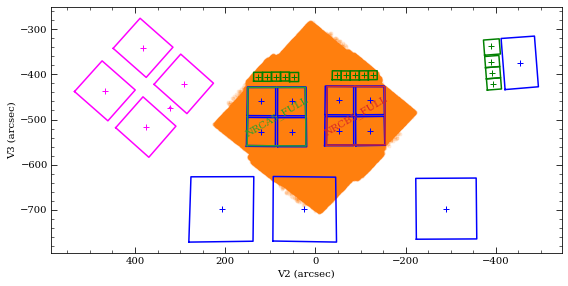

In [15]:
# Plot aperture files
fig, ax = plt.subplots(1,1)

# V2/V3 positions of all objects
ax.plot(v2_obj, v3_obj, marker='.', alpha=0.1, ls='None', color='C1')

# Plot all the telescope aperture (NIRCam, NIRSpec, NIRIS, MIRI, and FGS)
plot_main_apertures(ax=ax, fill=False, mark_ref=True)

nrc_a5.plot(ax=ax, fill=False, color='C2', label=True)
nrc_b5.plot(ax=ax, fill=False, color='C3', label=True)

fig.tight_layout()

# Simulate Field

### Functions for simulations

In [16]:
def ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, base_off=(0,0), dith_off=(0,0),
             get_cenpos=True, get_vert=False):
    """Aperture reference point(s) RA/Dec
    
    Return RA/Dec associated with the reference point (usually center) 
    of a specific aperture.
    
    Parameters
    ----------
    ap_obs : str
        Name of observed aperture (e.g., NRCA5_FULL)
    ap_ref : str
        Name of reference aperture (e.g., NRCALL_FULL)
    coord_ref : tuple or list
        Center position of reference aperture (RA/Dec deg)
    pa_ref : float
        Position angle of ap_ref
        
    Keywords
    --------
    base_off : list or tuple
        X/Y offset of overall aperture offset (see APT pointing file)
    dither_off : list or tuple
        Additional offset from dithering (see APT pointing file)
    get_cenpos : bool
        Return aperture reference location coordinates?
    get_vert: bool
        Return closed polygon vertices (useful for plotting)?
    """

    if (get_cenpos==False) and (get_vert==False):
        print("Neither get_cenpos nor get_vert were set to True. Nothing to return.")
        return

    nrc_siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = nrc_siaf[ap_ref]
    ap_siaf_obs = nrc_siaf[ap_obs]

    # RA and Dec of ap ref location and the objects in the field
    ra_ref, dec_ref = coord_ref

    # Field offset as specified in APT Special Requirements
    x_off, y_off  = (base_off[0] + dith_off[0], base_off[1] + dith_off[1])

    # V2/V3 reference location aligned with RA/Dec reference
    v2_ref, v3_ref = np.array(ap_siaf.reference_point('tel'))
    
    # Attitude correction matrix relative to reference aperture
    att = pysiaf.utils.rotations.attitude(v2_ref-x_off, v3_ref+y_off, ra_ref, dec_ref, pa_ref)

    # Get V2/V3 position of observed SIAF aperture and convert to RA/Dec
    if get_cenpos==True:
        v2_obs, v3_obs  = ap_siaf_obs.reference_point('tel')
        ra_obs, dec_obs = pysiaf.utils.rotations.pointing(att, v2_obs, v3_obs)
        cen_obs = (ra_obs, dec_obs)
    
    # Get V2/V3 vertices of observed SIAF aperture and convert to RA/Dec
    if get_vert==True:
        v2_vert, v3_vert  = ap_siaf_obs.closed_polygon_points('tel', rederive=False)
        ra_vert, dec_vert = pysiaf.utils.rotations.pointing(att, v2_vert, v3_vert)
        vert_obs = (ra_vert, dec_vert)

    if (get_cenpos==True) and (get_vert==True):
        return cen_obs, vert_obs
    elif get_cenpos==True:
        return cen_obs
    elif get_vert==True:
        return vert_obs
    else:
        print("Neither get_cenpos nor get_vert were set to True. Nothing to return.")
        return


In [17]:
def mag_to_counts(src_mag, bandpass, sp_type='flat'):
    """
    Convert stellar magnitudes in some bandpass to flux values
    """
    
    # Get flux of a 0 magnitude star (zero-point flux)
    sp = pynrc.stellar_spectrum(sp_type, 0, 'vegamag', bandpass)
    obs = S.Observation(sp, bandpass, binset=bandpass.wave)
    zp_counts = obs.effstim('counts') # Counts of a 0 mag star
    
    # Flux of each star e-/sec
    src_flux = np.array(zp_counts * 10**(-src_mag / 2.5))
    
    return src_flux

In [18]:
# Functions for generating oversized image of a given module 
# assuming detectors spanned entire field of view.
# These will eventually get reduced to the specific detector.


def pickoff_image(ap_obs, v2_obj, v3_obj, flux_obj):
    """
    Create unconvolved image of objects within pickoff mirror FoV
    
    ap_obs  : Aperture to create observation (e.g., 'NRCA5_FULL')
    v2_obj  : V2 locations of stellar sources
    v3_obj  : V3 locations of stellar soruces
    flux_obj : Corresponding source fluxes (counts/sec)
    """
    
    # xpix and ypix locations
    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_obs]
    module = ap_obs[3:4]
    
    xpix, ypix = ap_siaf.tel_to_det(v2_obj, v3_obj)
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    
    # Mask all sources that are outside pick-off mirror
    # x1, x2, y1, y2 = [-100, 2148, -100, 2148]
    mask = ((xpix>x1) & (xpix<x2-1)) & ((ypix>y1) & (ypix<y2-1))
    xpix = xpix[mask]
    ypix = ypix[mask]
    src_flux = flux_obj[mask]

    # Zero-based (x,y) locations for oversized images
    xvals_os = xpix - x1
    yvals_os = ypix - y1

    # separate into an integers and fractions
    intx = xvals_os.astype(np.int)
    inty = yvals_os.astype(np.int)
    fracx = xvals_os - intx
    fracy = yvals_os - inty

    # flip negative shift values
    ind = fracx < 0
    fracx[ind] += 1
    intx[ind] -= 1
    ind = fracy<0
    fracy[ind] += 1
    inty[ind] -= 1

    # Bilinear interpolation of all sources
    val1 = src_flux * ((1-fracx)*(1-fracy))
    val2 = src_flux * ((1-fracx)*fracy)
    val3 = src_flux * ((1-fracy)*fracx)
    val4 = src_flux * (fracx*fracy)

    # Create oversized image
    ys = y2 - y1
    xs = x2 - x1
    oversized_image = np.zeros([ys,xs])
    # Add star-by-star in case of overlapped indices
    for i, (iy, ix) in enumerate(zip(inty,intx)):
        oversized_image[iy,   ix]   += val1[i]
        oversized_image[iy+1, ix]   += val2[i]
        oversized_image[iy,   ix+1] += val3[i]
        oversized_image[iy+1, ix+1] += val4[i]
        
    #print("NStars: {}".format(len(intx)))
    
    return oversized_image


def pickoff_xy(ap_obs):
    """
    Return pickoff mirror FoV x/y limits in terms of detector pixel coordinates
    
    ap_obs : Aperture to create observation (e.g., 'NRCA5_FULL')
    """

    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_obs]
    module = ap_obs[3:4]

    # Determine pick-off mirror FoV
    ap1 = siaf['NRC{}5_GRISMC_WFSS'.format(module)]
    ap2 = siaf['NRC{}5_GRISMR_WFSS'.format(module)]
    ap3 = siaf['NRCA5_FULL_MASK335R']

    # V2/V3 coordinates of pick-off FoV
    v2_1, v3_1 = ap1.corners('tel', False)
    v2_2, v3_2 = ap2.corners('tel', False)
    v2_3, v3_3 = ap3.corners('tel', False)
    if module == 'B': v2_3 *= -1
    v2_all = np.array([v2_1, v2_2, v2_3]).flatten()
    v3_all = np.array([v3_1, v3_2, v3_3]).flatten()

    # Convert to pixel positions
    x_new, y_new = ap_siaf.tel_to_det(v2_all, v3_all)
    x1, x2 = (int(x_new.min()), int(x_new.max()))
    y1, y2 = (int(y_new.min()), int(y_new.max()))

    return (x1, x2, y1, y2)


def build_cmask(ap_obs):
    """
    Build unconvolved image of coronagraphic mask (det orientation)
    
    ap_obs : Detector aperture to crop cmask (e.g., 'NRCA5_FULL')
    """
    
    # Limits of pickoff mirror w.r.t. observed aperture
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    ys = y2 - y1
    xs = x2 - x1
    
    # Attenuate stars intercepting coronagraphic mask
    module = ap_obs[3:4]
    detid = '{}5'.format(module)
    cmask = nrc_utils.build_mask_detid(detid)
    try:
        cmask = nrc_utils.sci_to_det(cmask, detid)
    except AttributeError:
        cmask = nrc_utils.V2V3_to_det(cmask, detid)
    cmask = nrc_utils.pad_or_cut_to_size(cmask, (ys,xs), fill_val=1)
    
    if detid=='A5':
        dy = (ys-2048)/2
        dx = -(xs-2048)/2 - x1
        cmask = nrc_utils.fshift(cmask, delx=int(dx), dely=int(dy))

        i1, i2 = [int(1500+dy*2), int(260-x1)]
        cmask[i1:,0:i2]=0
        i1, i2 = [int(1500+dy*2), int(1900-x1)]
        cmask[i1:,i2:]=0
    elif detid=='B5':
        dy = -(ys-2048)/2
        dx = -(xs-2048)/2 - x1
        cmask = nrc_utils.fshift(cmask, delx=int(dx), dely=int(dy))

        i1, i2 = [int(550), int(200-x1)]
        cmask[0:i1,0:i2]=0
        i1, i2 = [int(550), int(1830-x1)]
        cmask[0:i1,i2:]=0
        
    return cmask


In [73]:
def gen_slope(nrc, ap_ref, coord_ref, pa_ref, tbl_objs, ap_obs=None, base_off=(0,0), dith_off=(0,0)):
    
    """
    Generate slope image 
    
    nrc       : pynrc NIRCam class housing PSF and MULTIACCUM info
    ap_ref    : Aperture name ('NRCALL_FULL') of reference coordinates
    coord_ref : List or tuple of RA & Dec towards which ap_ref points
    pa_ref    : Position angle of ap_ref
    tbl_objs  : Table of object positions and filter mags
    
    ap_obs     : Aperture to create observation (e.g., 'NRCA5_FULL')
    base_off   : X/Y offset of overall aperture offset (see APT pointing file)
    dither_off : Additional offset from dithering (see APT pointing file)
    """
    
    ap_obs = ap_ref if ap_obs is None else ap_obs
        
    # Convert all RA/Dec coordinates into V2/V3 positions for objects
    ra_deg, dec_deg = (tbl_objs['ra'], tbl_objs['dec'])
    v2_obj, v3_obj = radec_to_v2v3((ra_deg, dec_deg), ap_ref, coord_ref, pa_ref, 
                                   base_off=base_off, dith_off=dith_off)
    
    # Get flux and pixel locations of all sources
    src_mag  = tbl_objs[nrc.bandpass.name]
    src_flux = mag_to_counts(src_mag, nrc.bandpass)
    
    # Generate oversized image of pickoff mirror
    oversized_image = pickoff_image(ap_obs, v2_obj, v3_obj, src_flux)
    
#     # Generate coronagraphic mask image in detector orientation
    cmask = None
#     cmask = build_cmask(ap_obs)
    
#     # Attenuate stars by cmask
#     oversized_image *= cmask
        
    # Get PSFs
    fov_pix = nrc.psf_info['fov_pix']
    try:
        psf_os = nrc.psf_offaxis_over
        psf = nrc_utils.krebin(psf_os, (fov_pix,fov_pix))
    except AttributeError:
        psf = nrc.gen_psf(return_oversample=False, use_bg_psf=True)
        
    # Convolve with detector-sampled PSF
    # Normalize PSF during convolution
    norm = psf.sum()
    res = convolve_fft(oversized_image, psf/norm, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)
    res[res<0] = 0
    res *= norm
    
    #print('Convolving zodiacal light image')
    if cmask is None:
        im_zodi = nrc.bg_zodi()
    else:
        # Add in zodiacal light attenuated by coronagraphic mask
        im_zodi = cmask * nrc.bg_zodi()

        # Convolve with PSF (coronagraphic mask sits behind Lyot stop)
        # bg_zodi() already includes PSF reduction from Lyot stop
        # So, we want a normalized PSF to 1 for Lyot observations
        im_zodi = convolve_fft(im_zodi, psf/norm, fftn=fftpack.fftn, ifftn=fftpack.ifftn, allow_huge=True)
        if nrc.pupil=='CLEAR': im_zodi *= norm
        im_zodi[im_zodi<0] = 0
    
    # Add to stellar image
    res += im_zodi
    del cmask, im_zodi

    # Cut out postage stamp
    x1, x2, y1, y2 = pickoff_xy(ap_obs)
    res = res[-y1:2048-y1, -x1:2048-x1]
    
    # Zero reference pixels
    res[0:4,:] = 0
    res[:,0:4] = 0
    res[-4:,:] = 0
    res[:,-4:] = 0

    hdu = fits.PrimaryHDU(res)

    # Add header information
    hdr = hdu.header
    ra_obs, dec_obs = ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, 
                               base_off=base_off, dith_off=dith_off)
    hdr['RA']  = (ra_obs, 'RA (deg) of center pixel')
    hdr['DEC'] = (dec_obs, 'Dec (deg) of center pixel')
    hdr['BASE_RA']  = (coord_ref[0], 'RA (deg) target in APT')
    hdr['BASE_DEC'] = (coord_ref[1], 'Dec (deg) target in APT')
    hdr['BASEOFFX'] = (base_off[0], 'Offset X of target in APT')
    hdr['BASEOFFY'] = (base_off[1], 'Offset Y of target in APT')
    hdr['DITHOFFX'] = (dith_off[0], 'Offset X due to dithering')
    hdr['DITHOFFY'] = (dith_off[1], 'Offset Y due to dithering')

    hdul = fits.HDUList(hdu)
    
    return hdul

In [93]:
def make_ramp_poisson(im_slope, det, out_ADU=True, zero_data=False):
    """
    Create a ramp with only photon noise.
    
    im_slope : Slope image (detector coordinates) in e-/sec
    det      : Detector information class
    out_ADU  : Convert to 16-bit UINT?
    zero_data: Return the so-called "zero frame"?
    """

    ma  = det.multiaccum

    xpix = det.xpix
    ypix = det.ypix

    nd1     = ma.nd1
    nd2     = ma.nd2
    nf      = ma.nf
    ngroup  = ma.ngroup
    t_frame = det.time_frame

    # Number of total frames up the ramp (including drops)
    naxis3 = nd1 + ngroup*nf + (ngroup-1)*nd2

    # Set reference pixels' slopes equal to 0
    w = det.ref_info
    if w[0] > 0: # lower
        im_slope[:w[0],:] = 0
    if w[1] > 0: # upper
        im_slope[-w[1]:,:] = 0
    if w[2] > 0: # left
        im_slope[:,:w[2]] = 0
    if w[3] > 0: # right
        im_slope[:,-w[3]:] = 0

    # Count accumulation for a single frame
    frame = im_slope * t_frame
    # Add Poisson noise at each frame step
    sh0, sh1 = im_slope.shape
    new_shape = (naxis3, sh0,sh1)
    ramp = np.random.poisson(lam=frame, size=new_shape)#.astype(np.float64)
    # Perform cumulative sum in place
    data = np.cumsum(ramp, axis=0)

    # Convert to ADU (16-bit UINT)
    if out_ADU:
        gain = det.gain
        data /= gain
        data[data < 0] = 0
        data[data >= 2**16] = 2**16 - 1
        data = data.astype('uint16')
        
    # Save the first frame (so-called ZERO frame) for the zero frame extension
    zeroData = deepcopy(data[0,:,:])

    # Remove drops and average grouped data
    if nf>1 or nd2>0:
        # Trailing drop frames already excluded, so need to pull off last group of avg'ed frames
        data_end = data[-nf:,:,:].mean(axis=0) if nf>1 else data[-1:,:,:]
        data_end = data_end.reshape([1,ypix,xpix])

        # Only care about first (n-1) groups
        # Last group is handled separately
        data = data[:-nf,:,:]

        # Reshape for easy group manipulation
        data = data.reshape([-1,nf+nd2,ypix,xpix])

        # Trim off the dropped frames (nd2)
        if nd2>0: data = data[:,:nf,:,:]

        # Average the frames within groups
        # In reality, the 16-bit data is bit-shifted
        data = data.reshape([-1,ypix,xpix]) if nf==1 else data.mean(axis=1)

        # Add back the last group (already averaged)
        data = np.append(data,data_end,axis=0)

        
    if zero_data==True:
        return (data, zeroData)
    else:
        return data

In [90]:
def create_WCS(obs, ap_obs, ap_ref, coord_ref, pa_ref, base_off=(0,0), dith_off=(0,0)):

    siaf = pysiaf.Siaf('NIRCAM')
    ap_siaf = siaf[ap_obs]
    
    wcs_obs = WCS(naxis=2)
    wcs_obs.pixel_shape = (obs.det_info['ypix'], obs.det_info['xpix'])
    
    ra, dec = ap_radec(ap_obs, ap_ref, coord_ref, pa_ref, base_off=base_off, dith_off=dith_off)
    wcs_obs.wcs.crval = [ra, dec]
    wcs_obs.wcs.ctype = ["RA---SIN", "DEC--SIN"]
    wcs_obs.wcs.radesys = 'FK5'
    wcs_obs.wcs.equinox = 2000

    wcs_obs.wcs.crpix = list(ap_siaf.reference_point('det'))
    wcs_obs.wcs.cdelt = np.array([-ap_siaf.XSciScale,ap_siaf.YSciScale]) / 3600

    wcs_obs.wcs.crota = np.array([0., 0.]) #np.array([ap_siaf.V3SciXAngle, ap_siaf.V3SciYAngle])
    
    return wcs_obs


In [64]:
# Reference aperture (NRCALL_FULL) for telescope pointing
siaf_ref_name = 'NRCALL_FULL'
coord_ref = (80.48750, -69.49750) # Reference RA/Dec of aperture
pa_ref = 0 # Position angle of aperture

# Table holding object information
tbl_objs = tbl

# Base offset from APT point file (BaseX, BaseY)
base_off=(-60,0)

# List of dither positions in APT pointing file
dith_list = [(-38.157, -13.687), (-37.917, -13.511), (-29.967,  -5.497), (-29.727,  -5.321), 
             (-38.541, +12.564), (-38.301, +12.740), (-30.351, +20.754), (-30.111, +20.930), 
             (+38.157, +13.687), (+38.397, +13.863), (+46.347, +21.877), (+46.587, +22.053), 
             (+38.541, -12.564), (+38.781, -12.388), (+46.731,  -4.374), (+46.971,  -4.198)]

In [21]:
# Filter to observe with
filt = 'F335M'
# Aperture associated with observation (e.g, A5)
ap_obs = 'NRCA5_FULL'

# Set up pynrc NIRCam observation info for a single dither position
obs = pynrc.NIRCam(filter=filt, module='A',
                   wind_mode='FULL', fov_pix=513, oversample=2,
                   read_mode='BRIGHT1', ngroup=2, nint=2)

In [91]:
f = obs.filter
p = obs.pupil

outdir = 'output2/'
det = obs.Detectors[0]
for j, dith in enumerate(dith_list[0:1]):
    # RA/Dec associated with the center of observed aperture
    ra_obs, dec_obs = ap_radec(ap_obs, siaf_ref_name, coord_ref, pa_ref, 
                               base_off=base_off, dith_off=dith)

    # Get ideal slope image of dither position
    hdul_out = gen_slope(obs, siaf_ref_name, coord_ref, pa_ref, tbl_objs, 
                         ap_obs=ap_obs, base_off=base_off, dith_off=dith)
    
    # Put in 'sci' coordinate frame
#     detid = det.detid
#     try:
#         hdul_out[0].data = nrc_utils.sci_to_det(hdul_out[0].data, detid)
#     except AttributeError:
#         hdul_out[0].data = nrc_utils.V2V3_to_det(hdul_out[0].data, detid)
    
    # Copy some header keys
    hdr_in = det.make_header() #hdul_out[1].header
    hdr_out = hdul_out[0].header
    hdr_out.insert('EXTEND', ('UNITS', 'e-/sec', "Units for the data type (ADU, e-, etc.)"), after=True)
    hdr_keys = ['SCA_ID', 'DETECTOR', 'PIXELSCL', 'FOV', 'CHANNEL', 'FILTER', 'PUPIL']
    for k in hdr_keys:
        hdr_out[k] = (hdr_in[k], hdr_in.comments[k])
    hdr_out.insert(hdr_keys[0], '')
    hdr_out.insert(hdr_keys[0], ('','Instrument Setup'))
    hdr_out.insert(hdr_keys[0], '')
    hdr_out.insert('RA', '')
    hdr_out.insert('RA', ('','Pointing Info'))
    hdr_out.insert('RA', '')
    
    wcs_obs = create_WCS(obs, ap_obs, siaf_ref_name, coord_ref, pa_ref, base_off=base_off, dith_off=dith)
    hdr_out.update(wcs_obs.to_header())

    det_name = obs.Detectors[0].detid
    filename = outdir + 'LMC_ASTROMETRY_{}_{}_{}_pos{:02}.fits'.format(det_name,f,p,j)
    hdul_out.writeto(filename, overwrite=True)
    hdul_out.close()
        
